In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_rel
# import timedelta
from datetime import timedelta

In [2]:
df_cut_final = pd.read_csv('../../data/tidy/paired_data/final_data_for_analysis.csv')


In [6]:
df_iob_none = df_cut_final[df_cut_final['IOB']==0]

In [20]:
df_iob = df_cut_final[df_cut_final['IOB']>0]

In [23]:
df_iob_none.groupby('exercise')['glc_change'].describe()

,count,mean,std,min,25%,50%,75%,max
exercise,,,,,,,,
0,222.0,-0.116261,2.276787,-9.38,-1.0375,-0.28,0.660,10.16
1,230.0,-0.957652,3.089530,-10.55,-2.8250,-0.61,0.875,7.83


In [24]:
df_iob.groupby('exercise')['glc_change'].describe()

,count,mean,std,min,25%,50%,75%,max
exercise,,,,,,,,
0,1615.0,-0.333950,2.030071,-10.83,-1.36,-0.38,0.615,10.05
1,1607.0,-2.445943,2.742127,-12.84,-4.28,-2.39,-0.670,7.11


<Axes: xlabel='glc_change', ylabel='Count'>

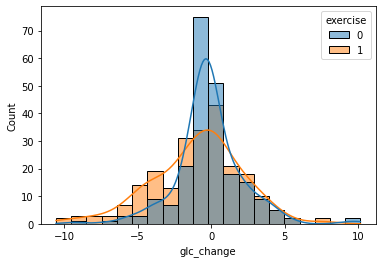

In [19]:
sns.histplot(df_iob_none, x='glc_change', hue='exercise', bins=20, kde=True)

/tmp/ipykernel_15157/2453854410.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="exercise", y="glc_change", data=df_iob_none, palette="coolwarm")


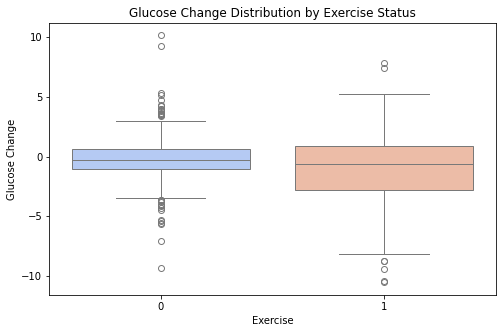

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(x="exercise", y="glc_change", data=df_iob_none, palette="coolwarm")

# Formatting
plt.xlabel("Exercise")
plt.ylabel("Glucose Change")
plt.title("Glucose Change Distribution by Exercise Status")

plt.show()


/tmp/ipykernel_15157/559958892.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="exercise", y="glc_change", data=df_iob, palette="coolwarm")


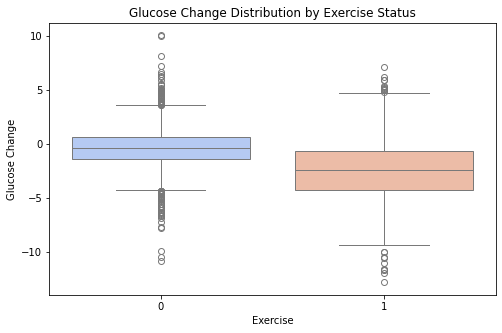

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(x="exercise", y="glc_change", data=df_iob, palette="coolwarm")

# Formatting
plt.xlabel("Exercise")
plt.ylabel("Glucose Change")
plt.title("Glucose Change Distribution by Exercise Status")

plt.show()


<Axes: >

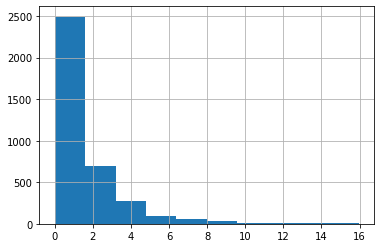

In [3]:
df_cut_final['IOB'].hist()

In [6]:
df_cut_final.groupby('exercise')['hypo'].sum()

exercise
0    0
1    0
Name: hypo, dtype: int64

In [4]:
# Count rows where glc_post_20 is less than 3.9, grouped by exercise
df_cut_final.groupby('exercise')['glc_post_20'].apply(lambda x: (x < 3.9).sum())


exercise
0     0
1    32
Name: glc_post_20, dtype: int64

In [5]:
32/1977.0

0.01618614061709661

In [6]:
df_cut_final.groupby('exercise')['glc_change'].describe()

,count,mean,std,min,25%,50%,75%,max
exercise,,,,,,,,
0,1837.0,-0.307643,2.062009,-10.83,-1.33,-0.34,0.66,10.16
1,1837.0,-2.259603,2.830299,-12.84,-4.11,-2.22,-0.39,7.83


In [7]:
# Sample grouped summary by ID and exercise group to get the mean (SD)
grouped = df_cut_final.groupby(['exercise'])[['start_roc', 'glc', 'cv','IOB']].agg(['mean', 'std']).reset_index()

# Initialize lists to store results
means = []
sds = []
smds = []
p_values = []

# Loop over each variable to calculate mean (SD), SMD, and p-value
for col in ['start_roc', 'glc', 'cv','IOB']:
    # Calculate mean (SD) for each exercise group
    exercise_means = grouped[grouped['exercise'] == 1][(col, 'mean')].mean()
    non_exercise_means = grouped[grouped['exercise'] == 0][(col, 'mean')].mean()
    exercise_sds = grouped[grouped['exercise'] == 1][(col, 'std')].mean()
    non_exercise_sds = grouped[grouped['exercise'] == 0][(col, 'std')].mean()
    
    # Store formatted mean (SD) strings
    means.append({
        'Variable': col,
        'Exercise Mean (SD)': f"{exercise_means:.2f} ({exercise_sds:.2f})",
        'Non-Exercise Mean (SD)': f"{non_exercise_means:.2f} ({non_exercise_sds:.2f})"
    })
    
    # Calculate SMD
    pooled_sd = np.sqrt((exercise_sds ** 2 + non_exercise_sds ** 2) / 2)
    smd = np.abs(exercise_means - non_exercise_means) / pooled_sd
    smds.append(smd)
    
    # Calculate paired p-value using t-test for paired samples
    exercise_vals = df_cut_final[df_cut_final['exercise'] == 1].groupby('ID')[col].mean()
    non_exercise_vals = df_cut_final[df_cut_final['exercise'] == 0].groupby('ID')[col].mean()
    
    if len(exercise_vals) == len(non_exercise_vals):  # Ensure pairs are matched
        t_stat, p_val = ttest_rel(exercise_vals, non_exercise_vals)
        p_values.append(p_val)
    else:
        p_values.append(np.nan)  # In case of mismatched pairs

# Combine results into a DataFrame
summary_table = pd.DataFrame(means)
summary_table['SMD'] = smds
summary_table['p-value'] = p_values



In [8]:
summary_table.round(2)

,Variable,Exercise Mean (SD),Non-Exercise Mean (SD),SMD,p-value
0,start_roc,0.01 (0.07),0.01 (0.06),0.00,0.63
1,glc,12.43 (2.24),12.39 (2.22),0.02,0.08
2,cv,8.24 (6.75),8.14 (6.61),0.01,0.04
3,IOB,1.52 (1.95),1.49 (1.91),0.02,0.04


In [9]:
df_cut_final.columns

Index(['bout_id', 'ID', 'start_datetime', 'duration', 'intensity',
       'type_of_exercise', 'finish_datetime', 'month', 'day', 'day_of_week',
       'time_of_day', 'form_of_exercise', 'time', 'glc', 'start_roc', 'IOB',
       'cv', 'avg_glucose', 'sd_glucose', 'time_below_3_9', 'time_3_9_to_10',
       'time_above_10', 'hbgi', 'glc_post_20', 'hypo', 'exercise',
       'glc_change', 'aer', 'ana', 'mix'],
      dtype='object')

In [10]:
df_cut_final['hour_of_day'] = pd.to_datetime(df_cut_final.start_datetime).dt.hour

In [11]:
df_cut_final.form_of_exercise.fillna('none', inplace=True)

/tmp/ipykernel_32347/2038511017.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cut_final.form_of_exercise.fillna('none', inplace=True)


In [12]:
df_cut_final['light']  = df_cut_final['intensity']==1
df_cut_final['moderate'] = df_cut_final['intensity']==2
df_cut_final['vigorous'] = df_cut_final['intensity']==3

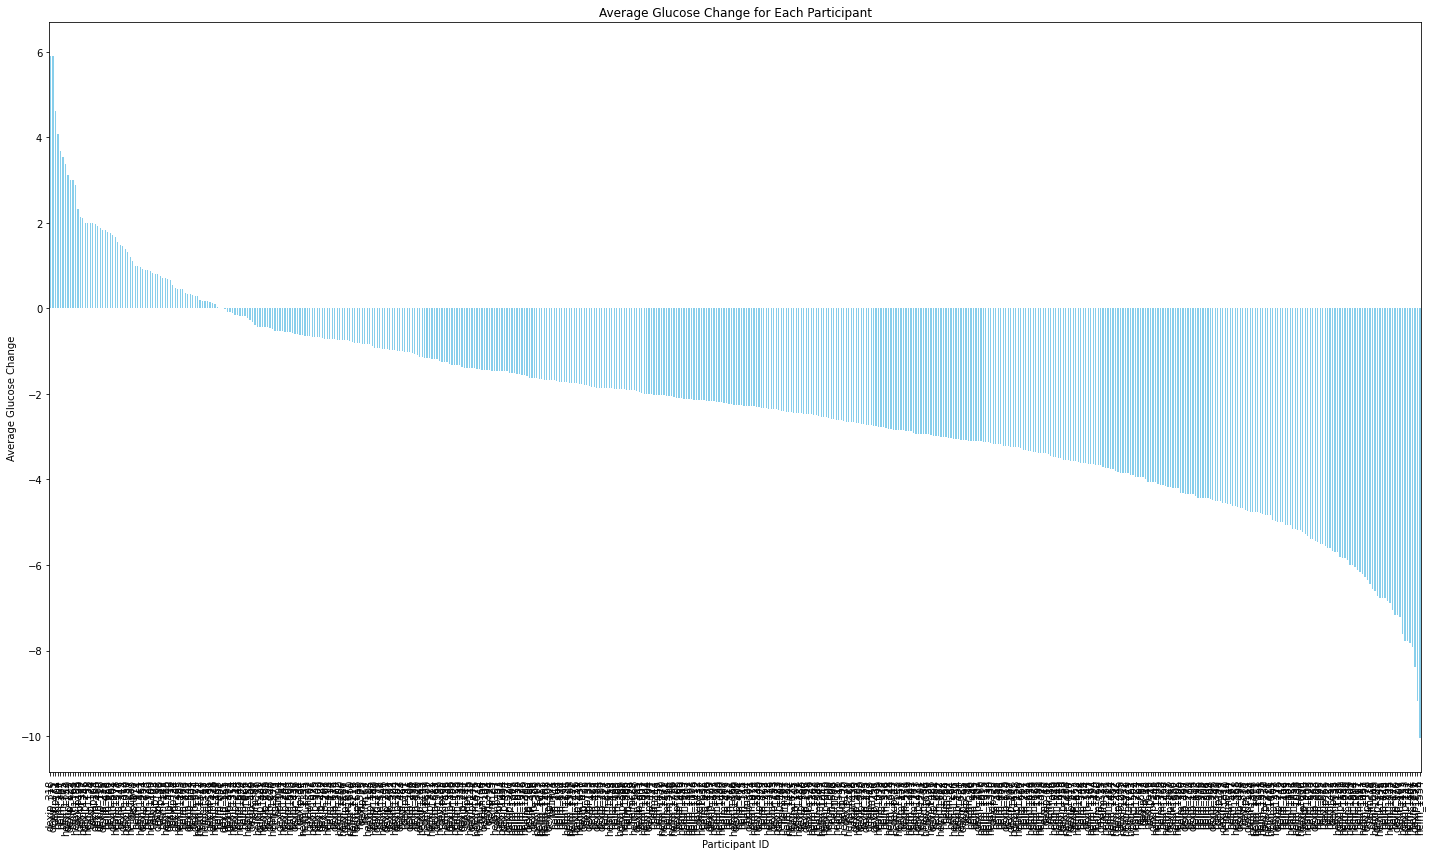

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

df_cut_final_helm = df_cut_final[(df_cut_final['exercise']==1)]

# Assuming 'glc_change' is the column representing glucose change and 'ID' is the participant identifier
# Group by ID and calculate the average glucose change for each participant
avg_glucose_change_per_id = df_cut_final_helm.groupby('ID')['glc_change'].mean()

avg_glucose_change_per_id = avg_glucose_change_per_id.sort_values(ascending=False)
# Plot the average glucose change per ID
plt.figure(figsize=(20, 12))
avg_glucose_change_per_id.plot(kind='bar', color='skyblue')
plt.xlabel('Participant ID')
plt.ylabel('Average Glucose Change')
plt.title('Average Glucose Change for Each Participant')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


In [24]:
avg_glucose_change

,Exercise,Non-Exercise
ID,,
helm_1357,2.112000,-0.214000
helm_862,1.770000,0.090000
helm_471,1.002000,0.060000
dexip_254,0.917500,-0.305000
helm_1100,0.873571,0.547857
...,...,...
helm_1033,-5.150000,-0.417500
helm_620,-5.456250,0.376250
dexip_181,-5.820000,-3.472500


In [36]:
avg_glucose_change

,Exercise,Non-Exercise
ID,,
dexip_101,-2.445000,0.495000
dexip_102,-1.670000,-2.275000
dexip_105,-0.840000,-1.780000
dexip_107,-2.170000,-0.137500
dexip_11,-4.720000,1.280000
...,...,...
helm_971,-0.750000,0.920000
helm_974,-2.290000,-0.207500
helm_976,-4.440000,-0.830000


In [37]:
avg_glucose_change_exercise

ID
dexip_318     5.890
dexip_175     5.890
dexip_71      4.610
helm_704      4.085
helm_367      3.670
              ...  
helm_1501    -7.830
helm_896     -7.915
dexip_251    -8.390
helm_1536    -9.170
helm_1554   -10.050
Name: glc_change, Length: 550, dtype: float64

In [38]:
avg_glucose_change_non_exercise

ID
helm_1361    7.080
dexip_88     6.230
helm_945     5.450
dexip_58     4.780
helm_1193    4.390
             ...  
dexip_231   -4.610
dexip_83    -4.660
dexip_257   -5.110
helm_491    -5.465
dexip_29    -5.580
Name: glc_change, Length: 550, dtype: float64

<Figure size 432x288 with 0 Axes>

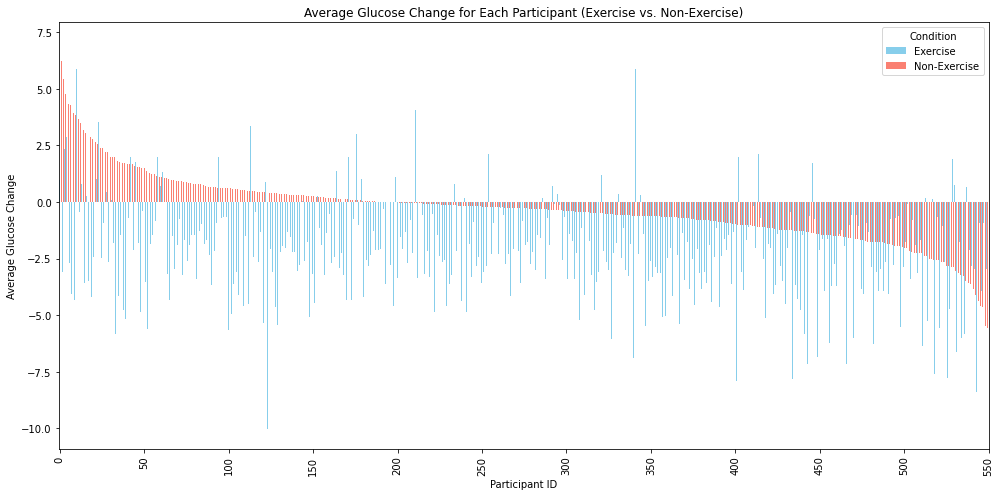

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter to keep only rows where each participant has more than 4 bouts
#df_cut_final_filtered = df_cut_final.groupby('ID').filter(lambda x: len(x) >= 6)

# Filter data for exercise == 1 and exercise == 0
df_exercise = df_cut_final[df_cut_final['exercise'] == 1]
df_non_exercise = df_cut_final[df_cut_final['exercise'] == 0]

# Calculate the average glucose change for each participant for both exercise and non-exercise
avg_glucose_change_exercise = df_exercise.groupby('ID')['glc_change'].mean()
avg_glucose_change_non_exercise = df_non_exercise.groupby('ID')['glc_change'].mean()

# Combine the results into a single DataFrame
avg_glucose_change = pd.DataFrame({
    'Exercise': avg_glucose_change_exercise,
    'Non-Exercise': avg_glucose_change_non_exercise
})

# Sort by average glucose change during exercise
avg_glucose_change = avg_glucose_change.sort_values(by='Non-Exercise', ascending=False)

# Plot the results
plt.figure()
avg_glucose_change.plot(kind='bar', color=['skyblue', 'salmon'], width=0.8, figsize=(14, 7))
plt.xlabel('Participant ID')
plt.ylabel('Average Glucose Change')
plt.title('Average Glucose Change for Each Participant (Exercise vs. Non-Exercise)')
# Set custom x-ticks in intervals of 50
num_participants = len(avg_glucose_change)
tick_positions = np.arange(0, num_participants+50, 50)  # Ticks at every 50 participants
tick_labels = [f"{i}" for i in tick_positions]  # Labels at every 50 participants

# Apply the custom ticks
plt.xticks(tick_positions, tick_labels, rotation=90)
plt.legend(title='Condition')
plt.tight_layout()
plt.show()


<Figure size 432x288 with 0 Axes>

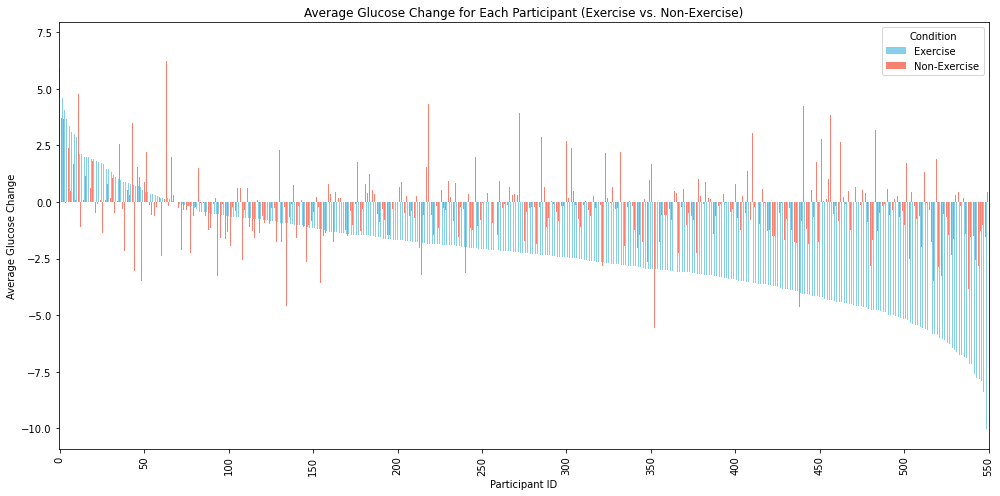

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter to keep only rows where each participant has more than 4 bouts
#df_cut_final_filtered = df_cut_final.groupby('ID').filter(lambda x: len(x) >= 6)

# Filter data for exercise == 1 and exercise == 0
df_exercise = df_cut_final[df_cut_final['exercise'] == 1]
df_non_exercise = df_cut_final[df_cut_final['exercise'] == 0]

# Calculate the average glucose change for each participant for both exercise and non-exercise
avg_glucose_change_exercise = df_exercise.groupby('ID')['glc_change'].mean()
avg_glucose_change_non_exercise = df_non_exercise.groupby('ID')['glc_change'].mean()

# Combine the results into a single DataFrame
avg_glucose_change = pd.DataFrame({
    'Exercise': avg_glucose_change_exercise,
    'Non-Exercise': avg_glucose_change_non_exercise
})

# Sort by average glucose change during exercise
avg_glucose_change = avg_glucose_change.sort_values(by='Exercise', ascending=False)
avg_glucose_change.dropna(inplace=True)
# Plot the results
plt.figure()
avg_glucose_change.plot(kind='bar', color=['skyblue', 'salmon'], width=0.8, figsize=(14, 7))
plt.xlabel('Participant ID')
plt.ylabel('Average Glucose Change')
plt.title('Average Glucose Change for Each Participant (Exercise vs. Non-Exercise)')
# Set custom x-ticks in intervals of 50
num_participants = len(avg_glucose_change)
tick_positions = np.arange(0, num_participants+50, 50)  # Ticks at every 50 participants
tick_labels = [f"{i}" for i in tick_positions]  # Labels at every 50 participants

# Apply the custom ticks
#plt.xticks(tick_positions, tick_labels, rotation=90)
plt.legend(title='Condition')
plt.tight_layout()
plt.show()
